## Pause - Differential Entropy and Control functions 

In [2]:
from src.data.components.helsinki import HelsinkiProminenceExtractor
from src.data.components.datasets import TokenTaggingDataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import gaussian_kde

from src.utils.text_processing import python_lowercase_remove_punctuation
from src.utils.text_processing import get_wordlist_from_string

# only to create a valid dataset
dummy_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_special_tokens=True)

### Load data

In [3]:
WAV_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTS"
LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel"
PHONEME_LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabelPhoneme"
DATA_CACHE = "/Users/lukas/Desktop/projects/MIT/data/cache"

TRAIN_FILE = "dev-clean"
VAL_FILE = "dev-clean"
TEST_FILE = "test-clean"

SAVE_DIR = (
    "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/emnlp/pause"
)

In [4]:
from src.data.pause_regression_datamodule import PauseRegressionDataModule as DataModule

In [5]:
dm = DataModule(
    wav_root=WAV_ROOT,
    lab_root=LAB_ROOT,
    phoneme_lab_root=PHONEME_LAB_ROOT,
    data_cache=DATA_CACHE,
    train_file=TRAIN_FILE,
    val_file=VAL_FILE,
    test_file=TEST_FILE,
    dataset_name="libritts",
    model_name="gpt2",
    score_last_token=True,
)

In [6]:
dm.setup()

Using GPT2 tokenizer
Dataloader: padding with token id: 50256
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/dev-clean', 'pauses')


Preprocessing samples: 100%|██████████| 4217/4217 [00:02<00:00, 1694.15it/s]


Failed 217/4217
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/dev-clean', 'pauses')


Preprocessing samples: 100%|██████████| 4217/4217 [00:02<00:00, 1893.81it/s]


Failed 217/4217
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/test-clean', 'pauses')


Preprocessing samples: 100%|██████████| 4389/4389 [00:02<00:00, 1855.21it/s]

Failed 270/4389
Train dataset size: 4000
Validation dataset size: 4000
Test dataset size: 4119


In [7]:
train_texts, train_labels = dm.train_texts, dm.train_durations
val_texts, val_labels = dm.val_texts, dm.val_durations
test_texts, test_labels = dm.test_texts, dm.test_durations

print(
    f"Lengths of train, val, test in samples: {len(train_texts), len(val_texts), len(test_texts)}"
)

Lengths of train, val, test in samples: (4217, 4217, 4389)


In [8]:
from src.utils.text_processing import assign_labels_to_sentences

all_train_words, all_train_labels = assign_labels_to_sentences(
    train_texts, train_labels
)
all_dev_words, all_dev_labels = assign_labels_to_sentences(val_texts, val_labels)

all_test_words, all_test_labels = assign_labels_to_sentences(test_texts, test_labels)

print(f"Words and labels train: {len(all_train_words), len(all_train_labels)}")
print(f"Words and labels dev: {len(all_dev_words), len(all_dev_labels)}")
print(f"Words and labels test: {len(all_test_words), len(all_test_labels)}")

Words and labels train: (72537, 72537)
Words and labels dev: (72537, 72537)
Words and labels test: (77979, 77979)


In [9]:
print(
    f"min max mean of train labels: {min(all_train_labels), max(all_train_labels), np.mean(all_train_labels)}"
)

min max mean of train labels: (0.0, 2.47, 0.024162565311496204)


### Kernel density estimation and Differential Entropy Computation

In [23]:
# bootstrapping to get confidence intervals
from sklearn.utils import resample
from scipy.stats import gaussian_kde
from src.utils.approximation import cross_validate_gkde_bandwidth
from src.utils.approximation import monte_carlo_diff_entropy

n_iterations = 10
n_train_size = int(len(all_train_labels) * 0.4)
n_dev_size = int(len(all_dev_labels) * 0.05)
n_test_size = int(len(all_test_labels) * 0.2)
print(
    f"n_train_size: {n_train_size}, n_dev_size: {n_dev_size}, n_test_size: {n_test_size}"
)

diff_entropy_list = []

for i in range(n_iterations):
    train_sample = resample(all_train_labels, n_samples=n_train_size)
    dev_sample = resample(all_dev_labels, n_samples=n_dev_size)
    test_sample = resample(all_test_labels, n_samples=n_test_size)
    best_bw = 0.01
    best_bw = cross_validate_gkde_bandwidth(train_sample, dev_sample)
    print(f"Best bandwidth: {best_bw}")
    density = gaussian_kde(all_train_labels, bw_method=best_bw)
    mc_entropy = monte_carlo_diff_entropy(density, test_sample, len(test_sample))
    # if not infinite
    if mc_entropy != float("inf"):
        diff_entropy_list.append(mc_entropy)
    print(
        f"Finished iteration {i+1} out of {n_iterations} with diff entropy: {mc_entropy}"
    )

diff_entropy_list = np.array(diff_entropy_list)
print(f"Mean: {np.mean(diff_entropy_list)}, std: {np.std(diff_entropy_list)}")

n_train_size: 29014, n_dev_size: 3626, n_test_size: 15595
param scott, score 2.872157097207109
new best param scott, score 2.872157097207109
param silverman, score 2.825758295507382
param 0.01, score 5.009762990359984
new best param 0.01, score 5.009762990359984
param 0.1, score 3.0771537408057608
param 0.3, score 2.1815405632528933
Best bandwidth: 0.01
Finished iteration 1 out of 10 with diff entropy: inf
param scott, score 2.781878314497113
new best param scott, score 2.781878314497113
param silverman, score 2.735646407302966
param 0.01, score 5.160791283620377
new best param 0.01, score 5.160791283620377
param 0.1, score 2.984286448979089
param 0.3, score 2.092690623597022
Best bandwidth: 0.01
Finished iteration 2 out of 10 with diff entropy: -5.186687780384533
param scott, score 2.911348098567825
new best param scott, score 2.911348098567825
param silverman, score 2.8628548913198433
param 0.01, score 5.262936125227577
new best param 0.01, score 5.262936125227577
param 0.1, score 3.

In [11]:
from src.utils.approximation import cross_validate_gkde_bandwidth

best_bw = cross_validate_gkde_bandwidth(
    all_train_labels[:20000], all_test_labels[:5000]
)
print(f"best bw {best_bw}")

param scott, score 2.6791505821532557
new best param scott, score 2.6791505821532557
param silverman, score 2.6327444077416695
param 0.01, score 4.744609990442042
new best param 0.01, score 4.744609990442042
param 0.1, score 2.940804924670698
param 0.3, score 2.038663970621767
best bw 0.01


In [26]:
np.log(0.000001)

-13.815510557964274

In [12]:
# rule of thumb bandwidth estimator h = 1.06 * sigma * n^(-1/5)
# sigma = np.std(all_train_labels)
# n = len(all_train_labels)
# h = 1.06 * sigma * n ** (-1 / 5)
# print(f"bandwidth rule of thumb {h}")A

density = gaussian_kde(all_train_labels, bw_method=0.1)

In [13]:
from src.utils.approximation import monte_carlo_diff_entropy

diff_entropy = monte_carlo_diff_entropy(density, all_test_labels, 5000)
print(f"Differential entropy: {diff_entropy:.4f}")

Differential entropy: -2.9969


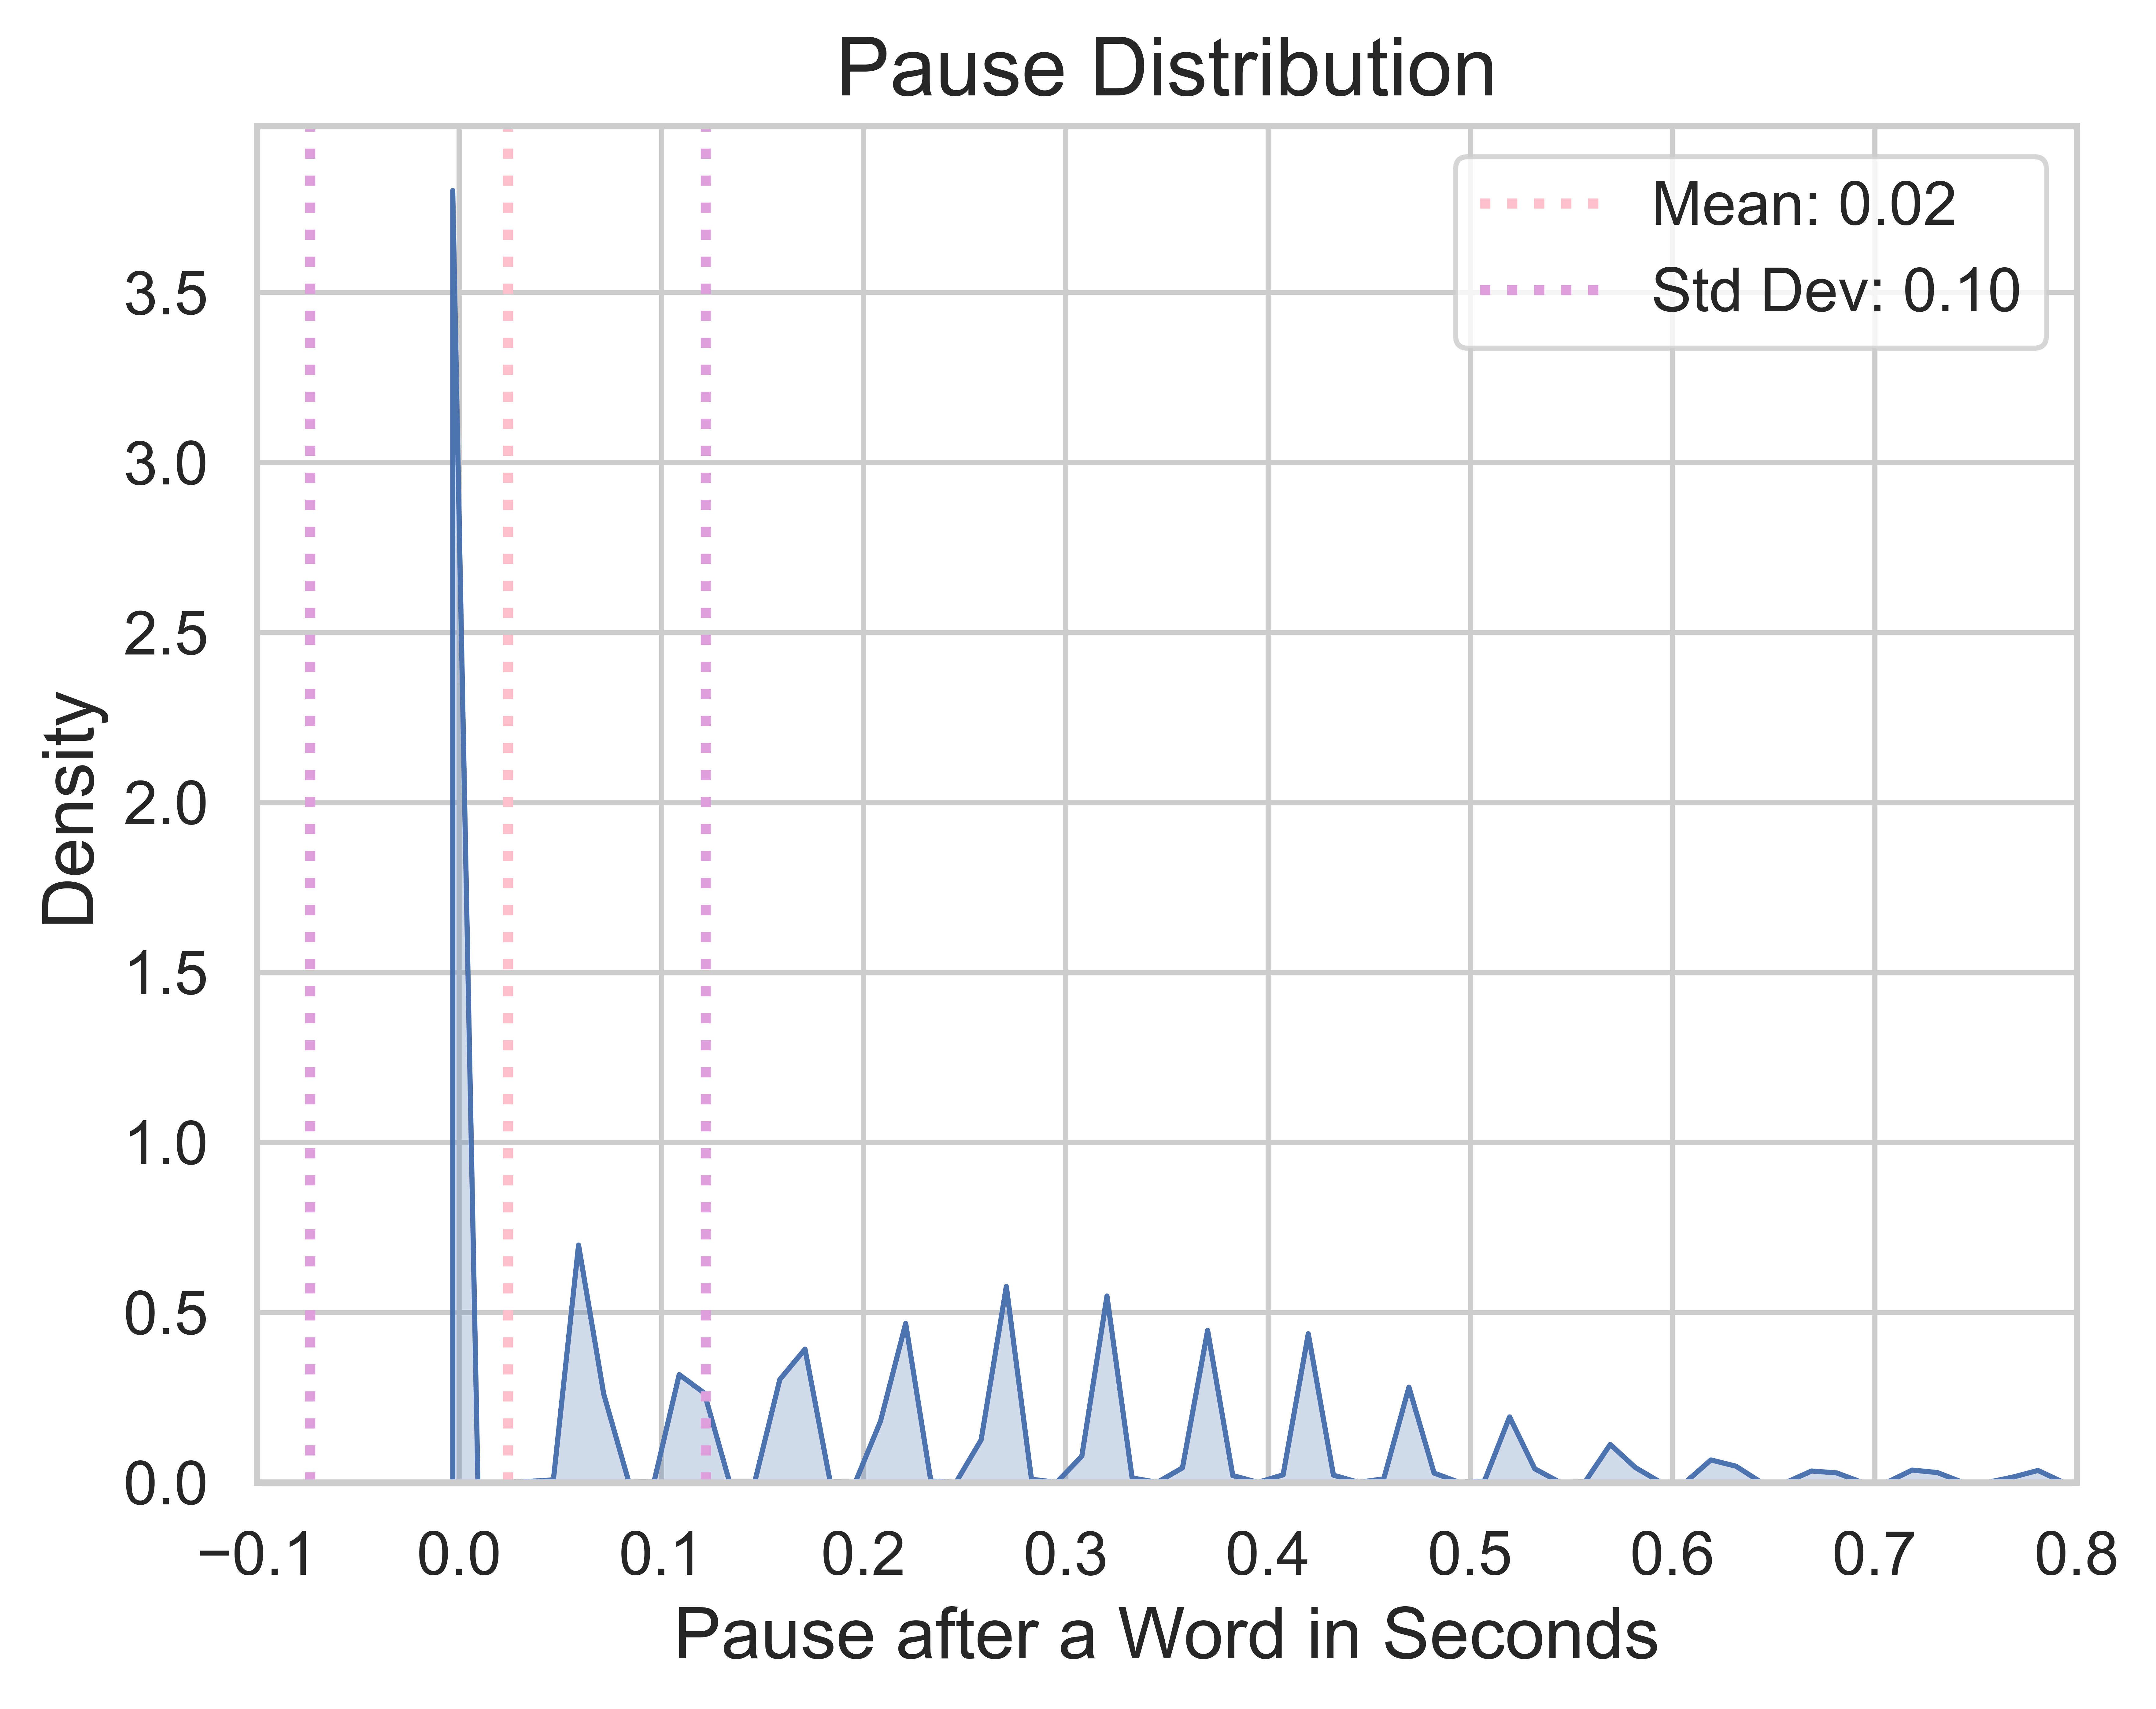

In [14]:
from src.utils.plots import plot_kde

x_min, x_max = np.min(all_train_labels), np.max(all_train_labels)

plot_kde(
    all_train_labels,
    bw_adjust=0.1,
    label_name="Pause after a Word in Seconds",
    title="Pause Distribution",
    x_range=(-0.1, 0.8)
    # save_path="/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/emnlp/pause_distribution.png",
)

## Store text and labels as pickle 

In [15]:
SAVE_PATH = "/Users/lukas/Desktop/projects/MIT/data/baseline_data/pause"

In [16]:
import pickle

with open(SAVE_PATH + "/train_words.pkl", "wb") as f:
    pickle.dump(all_train_words, f)

with open(SAVE_PATH + "/train_labels.pkl", "wb") as f:
    pickle.dump(all_train_labels, f)

with open(SAVE_PATH + "/test_words.pkl", "wb") as f:
    pickle.dump(all_test_words, f)

with open(SAVE_PATH + "/test_labels.pkl", "wb") as f:
    pickle.dump(all_test_labels, f)

with open(SAVE_PATH + "/dev_words.pkl", "wb") as f:
    pickle.dump(all_dev_words, f)

with open(SAVE_PATH + "/dev_labels.pkl", "wb") as f:
    pickle.dump(all_dev_labels, f)

# Baseline Models and Control Functions 

In [17]:
SAVE_PATH = "/Users/lukas/Desktop/projects/MIT/data/baseline_data/pause"

In [18]:
# load data again

import pickle


with open(SAVE_PATH + "/train_words.pkl", "rb") as f:
    all_train_words = pickle.load(f)

with open(SAVE_PATH + "/train_labels.pkl", "rb") as f:
    all_train_labels = pickle.load(f)

with open(SAVE_PATH + "/test_words.pkl", "rb") as f:
    all_test_words = pickle.load(f)

with open(SAVE_PATH + "/test_labels.pkl", "rb") as f:
    all_test_labels = pickle.load(f)

with open(SAVE_PATH + "/dev_words.pkl", "rb") as f:
    all_dev_words = pickle.load(f)

with open(SAVE_PATH + "/dev_labels.pkl", "rb") as f:
    all_dev_labels = pickle.load(f)

print(len(all_train_words), len(all_train_labels))
print(len(all_dev_words), len(all_dev_labels))
print(len(all_test_words), len(all_test_labels))

72537 72537
72537 72537
77979 77979


In [19]:
from src.models.baselines.GloVe import GloVeModel

glove_model = GloVeModel(
    model_path="/Users/lukas/Desktop/projects/MIT/data/models/glove/glove.6B.100d.txt"
)

Loading GloVe: 100%|██████████| 400000/400000 [00:06<00:00, 63788.31it/s]


In [20]:
train_emb = [glove_model.get_word_embedding(word) for word in all_train_words]
dev_emb = [glove_model.get_word_embedding(word) for word in all_dev_words]
test_emb = [glove_model.get_word_embedding(word) for word in all_test_words]

print(
    f"Shapes of train, dev, test embeddings: {len(train_emb)}, {len(dev_emb)}, {len(test_emb)}"
)

# create numpy arrays and print shapes
import numpy as np

train_emb = np.array(train_emb)
dev_emb = np.array(dev_emb)
test_emb = np.array(test_emb)

train_labels = np.array(all_train_labels)
dev_labels = np.array(all_dev_labels)
test_labels = np.array(all_test_labels)


print(
    f"Shapes of train, dev, test embeddings: {train_emb.shape}, {dev_emb.shape}, {test_emb.shape}"
)

print(
    f"Shapes of train, dev, test labels: {train_labels.shape}, {dev_labels.shape}, {test_labels.shape}"
)

Shapes of train, dev, test embeddings: 72537, 72537, 77979
Shapes of train, dev, test embeddings: (72537, 100), (72537, 100), (77979, 100)
Shapes of train, dev, test labels: (72537,), (72537,), (77979,)


# Sklearn LinReg

In [21]:
# train sklearn model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(train_emb, all_train_labels)

# compute mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

predictions = reg.predict(test_emb)
mse = mean_absolute_error(all_test_labels, predictions)
print(f"Mean absolute error: {mse}")

# compute r2
r2 = r2_score(all_test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(all_test_labels, predictions)
print(f"Pearson correlation: {pearson}")

Mean absolute error: 0.04144238105467682
R2 score: 0.048927032345058685
Pearson correlation: PearsonRResult(statistic=0.22195461105531306, pvalue=0.0)
